## Investigate DA-seq Results
#### Anna Möller anna.moeller@fau.de
_____
### 1. Import libraries:

In [1]:
import json
import pandas as pd 
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import numpy as np
import pandas as pd
import scipy.stats
import scipy
from statsmodels.stats.multitest import fdrcorrection
import scanpy as sc
import batchglm.api as glm
import diffxpy.api as de

print("batchglm version "+glm.__version__)
print("diffpy version "+de.__version__)

2023-08-06 22:15:22.465079: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-06 22:15:22.466204: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-06 22:15:22.489926: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-06 22:15:22.490525: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-06 22:15:22.884642: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

batchglm version v0.7.4
diffpy version v0.7.4


_____
### 1. Read results

In [4]:
labels = pd.read_csv("df_new_temp.csv")
my_file = open("DA_regions_cells.txt", "r")
data = my_file.read()
da_regions = data.split("\n")
my_file.close()
flat_list = []
for item in da_regions:
    try:
        item = item.split(']')[1].strip()  # Remove the part before ']'
        flat_list.extend(item.split())  # Split and extend the flat_list
        
    except:
        print(item)
        continue

In [5]:
len(flat_list)

189595

In [6]:
labels = labels.drop("Unnamed: 0", axis=1)
#labels = labels.set_index("label")
labels["da_regions"] = flat_list
labels["da_regions"] = labels["da_regions"].astype(int)
#labels["condition"] = np.where(labels['label'].str.contains("ALS"), "Case", "Control")
labels["condition"] = np.where(labels['label'].str.contains("ALS"), 1, 0)

labels["sample"] = labels["label"].str[:-12]

___
## 2. Visualize Distribution

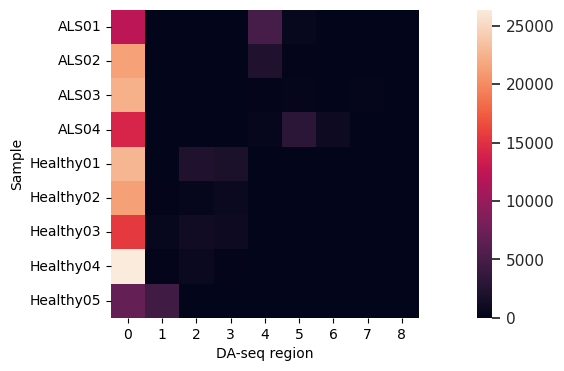

In [22]:
leiden = labels["da_regions"]
sample = labels["sample"].values.astype(str)

leiden_labels = np.unique(leiden)
samples = np.unique(sample)

conf = np.zeros((len(leiden_labels), len(samples)))
for i, l in enumerate(leiden_labels):
    for j, s in enumerate(samples):             
        conf[i,j] = len(np.where(sample[np.where(leiden == l)] == s)[0])
        
df = pd.DataFrame(conf.T, columns=leiden_labels, index=samples)

plt.subplots(figsize=(15,4))
sns.set_theme(style="white")
sns.heatmap(df,square=True)
plt.ylabel("Sample")
plt.xlabel("DA-seq region")
plt.savefig("daseq_cells_heatmap_samples.png")

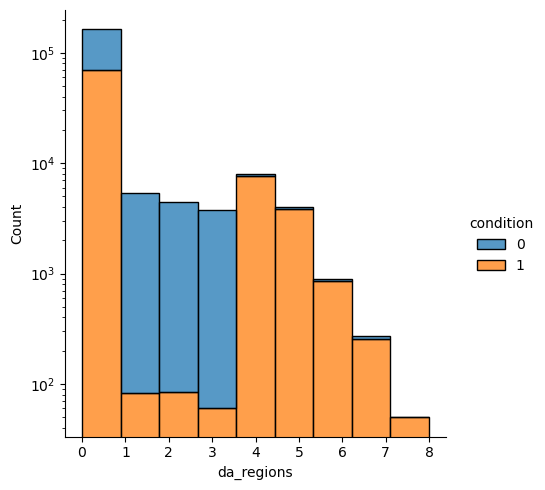

In [10]:
#plt.clf()
#labels = labels[labels["da_regions"] != 0]
sns.displot(labels , x="da_regions", hue="condition", kind="hist", multiple="stack", bins=len(np.unique(labels["da_regions"].values)))
#plt.yscale("log")
plt.xticks(range(len(np.unique(labels["da_regions"].values))))
plt.yscale("log")
plt.show()

<Figure size 640x480 with 0 Axes>

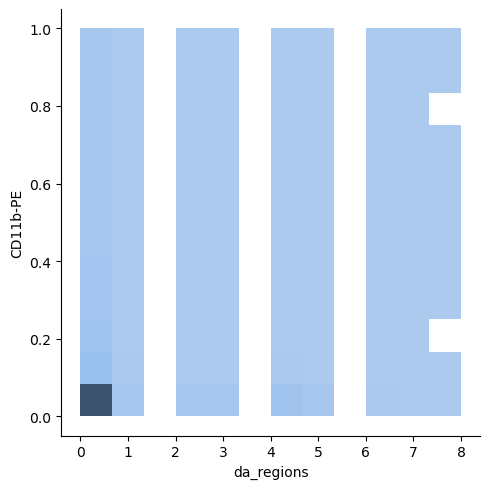

In [11]:
plt.clf()
sns.displot(labels, x="da_regions", y='CD11b-PE', bins=12)

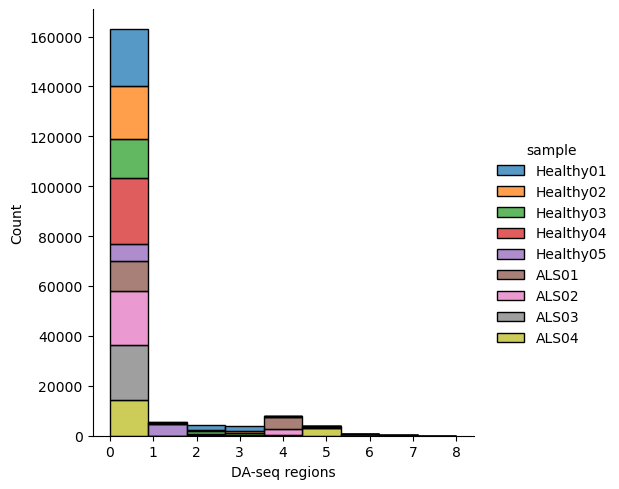

In [12]:
#plt.clf()
#labels = labels[labels["da_regions"] != 0]
sns.displot(labels, x="da_regions", hue="sample", kind="hist", multiple="stack", bins=len(np.unique(labels["da_regions"].values)))
#plt.yscale("log")
plt.xticks(range(len(np.unique(labels["da_regions"].values))))
plt.xlabel("DA-seq regions")
#plt.yscale("log")

plt.savefig("daseq_nuclei.png")
plt.show()

___
## 3. Statistical testing
Experiment with different statistical tests, e.g. Mann-Whitney-'U or Kruskal

In [2]:
# normalize:
labels.iloc[:,:-4] = (labels.iloc[:,:-4] - labels.iloc[:,:-4].mean(axis=0)) / labels.iloc[:,:-4].std(axis=0)

NameError: name 'labels' is not defined

In [48]:
regions = np.unique(labels["da_regions"].values)

genes = np.array(labels.columns[:-5])
all_pvalues = np.ndarray((len(regions), len(genes))) 
    
#for i, region in enumerate(regions):#
#    print(region)
#    pvals = {}

for gene in genes:
    #x_cells = labels[labels["da_regions"] == region]
    #y_cells = labels[labels["da_regions"] == 0]
    #x = x_cells[gene].values        
    
    #y = y_cells[gene].values
    l = [np.array(labels[labels["da_regions"] == region][gene]) for region in regions]
    pvals[gene] = scipy.stats.kruskal(l[0], l[1], l[2], l[3], l[4], l[5], l[6], l[7], l[8]).pvalue
    print(pvals[gene])

3.007047618812969e-212
0.0
0.0
1.0048954177239986e-87
0.0
5.312442634537017e-141
0.0
0.0
1.285612788383871e-269
4.776028480109526e-273
1.4791091044932174e-81
6.268203291112512e-144
2.0493737299130035e-110
6.018317326617625e-165
1.5242978586714602e-82
7.098215498129308e-260
9.033648237992188e-40
0.0
0.0


In [49]:
corrected = all_pvalues.copy()
for i, col  in enumerate(corrected.T):
    col = fdrcorrection(col)[0]
    corrected[:,i] = col
    
#original_shape = all_pvalues.shape
#corrected = fdrcorrection(all_pvalues.flatten())
#all_pvalues = corrected[0].reshape(original_shape)

In [51]:
res = pd.DataFrame(corrected, columns=genes, index=regions, dtype=bool)
res

,CD11b-PE,CD16-PE,CD2-FITC,CD26-PE,CD29-FITC,CD3-PE,CD36-FITC,CD38-PE,CD4-PE,CD45-PE,CD45RA-PE,CD56-PE,CD57-PE,CD7-PE,CD8-PE,HLA-DQ-FITC,HLA-DR-PE,NeuN-AF488,PBS
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
5,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
6,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
8,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
